##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.optim as op

In [ ]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [ ]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [ ]:

df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [ ]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [ ]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [ ]:
df.head()


,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


The input variables are the columns X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, and Time. The target variable(s) is VictimCount.

The range of the values in the columns do not seem to need any normalizing or shifting, they are all relatively close in value to each other in each respective column.

## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [ ]:
from torch.utils.data.dataset import TensorDataset
x = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']].values
y = df['VictimCount'].values
y = y.reshape(-1,1)

# Checking the shape of the input and target data
print(f"Input data shape: {x.shape}")
print(f"Target data shape: {y.shape}")


dataset = TensorDataset(torch.Tensor(x), torch.Tensor(y))

batchSize = 64

trainSize = int(0.8 * len(dataset))
testSize = len(dataset)-trainSize

train, test = torch.utils.data.random_split(dataset, [trainSize, testSize])


trainLoader = DataLoader(train, batch_size=batchSize, shuffle=True)
testLoader = DataLoader(test, batch_size=batchSize, shuffle=False)

#Checking shapes of input and target again
for i, (inputs, targets) in enumerate(trainLoader):
    print(f"Training Batch {i+1} input shape: {inputs.shape}, target shape: {targets.shape}")

for i, (inputs, targets) in enumerate(testLoader):
    print(f"Testing Batch {i+1} input shape: {inputs.shape}, target shape: {targets.shape}")



Input data shape: (275, 6)
Target data shape: (275, 1)
Training Batch 1 input shape: torch.Size([64, 6]), target shape: torch.Size([64, 1])
Training Batch 2 input shape: torch.Size([64, 6]), target shape: torch.Size([64, 1])
Training Batch 3 input shape: torch.Size([64, 6]), target shape: torch.Size([64, 1])
Training Batch 4 input shape: torch.Size([28, 6]), target shape: torch.Size([28, 1])
Testing Batch 1 input shape: torch.Size([55, 6]), target shape: torch.Size([55, 1])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [ ]:
#Model
class FFNN(nn.Module):
  def __init__ (self, input_dim, hidden_dim, output_dim):
    super(FFNN, self).__init__()

    #Sigmoid activation for the regression problem
    self.activation = nn.Sigmoid()

     #Input Layer
    self.fc1 = nn.Linear(input_dim, hidden_dim)

    #Hidden Layer
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    #Output Layer
    self.fc3 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h1 = self.activation(self.fc1(x))
    h2 = self.activation(self.fc2(h1))
    out = self.fc3(h2)
    return out




2. The size of predicted output should be 1, because we are trying to measure the number of crime victims.

3. The choice of architecture for this specific task is a feed forward neural network. I chose this because it is fairly simple to implement and we had discussed this architecture previously in class. I used the sigmoid activation function as we discussed in class as well. I used three fully connected layers for this architecture.


In [ ]:
#Hyperparameters
input_dim = 6
hidden_dim = 64
output_dim =1
epochs = 100

#initializing model
model = FFNN(input_dim, hidden_dim, output_dim)

#MSE loss function for regression problem
lossFunction = nn.MSELoss()

optimizer = op.Adam(model.parameters(), lr = 0.0001)

#Training Loop
for i in range(epochs):
  model.train()
  for j, (inputs, targets) in enumerate(trainLoader):

    #Clear gradients
    optimizer.zero_grad()

    #Get predicted outputs via forward pass
    outputs = model(inputs)

    #Calculate loss
    loss = lossFunction(outputs, targets)

    #Getting gradients via backward pass
    loss.backward()

    #Update parameters
    optimizer.step()

  #Change model to evaluation so we can test
  model.eval()
  test_loss_total = 0
  with torch.no_grad():
    #Evaluating model on test data and getting test loss
    for inputs, targets in testLoader:
        outputs = model(inputs)
        test_loss = lossFunction(outputs, targets)
        test_loss_total += test_loss.item()

  #Average test loss(MSE) for given epoch
  mse = test_loss_total / len(testLoader)
  #Print MSE
  print(f'Epoch {i + 1}, Loss: {loss.item()}, Test MSE: {mse:.4f}')





Epoch 1, Loss: 1.0160902738571167, Test MSE: 1.0033
Epoch 2, Loss: 1.4183920621871948, Test MSE: 0.9841
Epoch 3, Loss: 1.1539744138717651, Test MSE: 0.9661
Epoch 4, Loss: 1.9641931056976318, Test MSE: 0.9495
Epoch 5, Loss: 1.3225277662277222, Test MSE: 0.9340
Epoch 6, Loss: 0.490102082490921, Test MSE: 0.9199
Epoch 7, Loss: 0.647499144077301, Test MSE: 0.9081
Epoch 8, Loss: 0.8464089632034302, Test MSE: 0.8969
Epoch 9, Loss: 1.6402848958969116, Test MSE: 0.8873
Epoch 10, Loss: 0.8352665901184082, Test MSE: 0.8782
Epoch 11, Loss: 1.3929872512817383, Test MSE: 0.8701
Epoch 12, Loss: 0.3989228308200836, Test MSE: 0.8630
Epoch 13, Loss: 0.46061888337135315, Test MSE: 0.8575
Epoch 14, Loss: 1.2272417545318604, Test MSE: 0.8527
Epoch 15, Loss: 0.9311440587043762, Test MSE: 0.8484
Epoch 16, Loss: 0.8570975661277771, Test MSE: 0.8445
Epoch 17, Loss: 0.8772006034851074, Test MSE: 0.8411
Epoch 18, Loss: 0.9322847723960876, Test MSE: 0.8383
Epoch 19, Loss: 0.6765562295913696, Test MSE: 0.8360
Epo

The model is currently training at a decent rate. From looking at the output and the corresponding MSE's, we can see with each epoch that the MSE decreases slgihlty each epoch with some exceptions. I changed the learning rate as well as reshaped the size of the target data to match the output which is a single dimensional tensor.

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

In [ ]:
#Getting number of unique classes in column VictimCount
classes = len(np.unique(df['VictimCount']))

#Converting values to type int
y_class = df['VictimCount'].values
y_class = y_class.astype(int)

#Hyperparameters
hidden_dim = 128
batchSize=64
output_dim_class = classes
epochs_class = 100

#FFNN model for this classification problem
class FFNNClassify(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(FFNNClassify, self).__init__()
    #self.activation = nn.Sigmoid()

    #Using ReLU to see if it will yield better results
    self.activation = nn.ReLU()

    #Added a few extra hidden layers to see if it improves models efficiency
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = nn.Linear(hidden_dim, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, hidden_dim)
    self.fc5 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h1 = self.activation(self.fc1(x))
    h2 = self.activation(self.fc2(h1))
    h3 = self.activation(self.fc3(h2))
    h4 =self.activation(self.fc4(h3))
    out = self.fc5(h4)
    return out

#TensorDataset for data
data_class = TensorDataset(torch.Tensor(x), torch.Tensor(y_class))

#Initializing classification model and creating data loaders for classification
model_class = FFNNClassify(input_dim, hidden_dim, output_dim_class)
train_class, test_class = torch.utils.data.random_split(data_class,[trainSize, testSize])
trainLoader_class = DataLoader(train_class, batch_size = batchSize, shuffle = True)
testLoader_class = DataLoader(test_class, batch_size=batchSize, shuffle = False)

#Using loss funtion cross entropy for classification
lossFunction_class = nn.CrossEntropyLoss()
optimizer_class = op.Adam(model_class.parameters(), lr =0.0001)

#Model Training
for epoch in range(epochs_class):
    model_class.train()
    for i, (inputs, targets) in enumerate(trainLoader_class):
        optimizer_class.zero_grad()
        outputs = model_class(inputs)
        loss = lossFunction_class(outputs, targets.long())
        loss.backward()
        optimizer_class.step()

    #Model evaluation and accuracy
    model_class.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets in testLoader_class:
            test_outputs = model_class(inputs)
            _, predicted = torch.max(test_outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        accuracy = 100*correct / total
        print(f'Epoch {epoch + 1}, Loss:{loss.item()}, Test Accuracy: {accuracy:.4f}')


Epoch 1, Loss:2.198605537414551, Test Accuracy: 47.2727
Epoch 2, Loss:1.6476110219955444, Test Accuracy: 47.2727
Epoch 3, Loss:1.5698684453964233, Test Accuracy: 47.2727
Epoch 4, Loss:1.3053802251815796, Test Accuracy: 47.2727
Epoch 5, Loss:1.342839002609253, Test Accuracy: 47.2727
Epoch 6, Loss:1.2737761735916138, Test Accuracy: 47.2727
Epoch 7, Loss:1.1447497606277466, Test Accuracy: 47.2727
Epoch 8, Loss:1.0930215120315552, Test Accuracy: 47.2727
Epoch 9, Loss:1.262621283531189, Test Accuracy: 47.2727
Epoch 10, Loss:1.310231328010559, Test Accuracy: 47.2727
Epoch 11, Loss:1.1575076580047607, Test Accuracy: 47.2727
Epoch 12, Loss:1.144666075706482, Test Accuracy: 47.2727
Epoch 13, Loss:1.2126203775405884, Test Accuracy: 47.2727
Epoch 14, Loss:1.0073469877243042, Test Accuracy: 47.2727
Epoch 15, Loss:0.8449071049690247, Test Accuracy: 47.2727
Epoch 16, Loss:1.1305065155029297, Test Accuracy: 47.2727
Epoch 17, Loss:1.0635851621627808, Test Accuracy: 47.2727
Epoch 18, Loss:1.04683661460

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

My experience with task 3 and 4 was challenging to say the least. The results are a bit difficult to interpret as they are different in output and evaluation. However, I do think that the model that handled the regression problem(Task 3) worked better. I say this because the MSE shows a gradual decrease throughout the evaluation, indicating that it's accuracy was continuing to improve throughout the training period. The accuracy of classification model remained almost constant throughout showing it's accuracy did not improve throughout training. Despite numerous adjustmeants to the hyperparameters and tinkering with layers, the classification model accuracy never significantly improved.


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


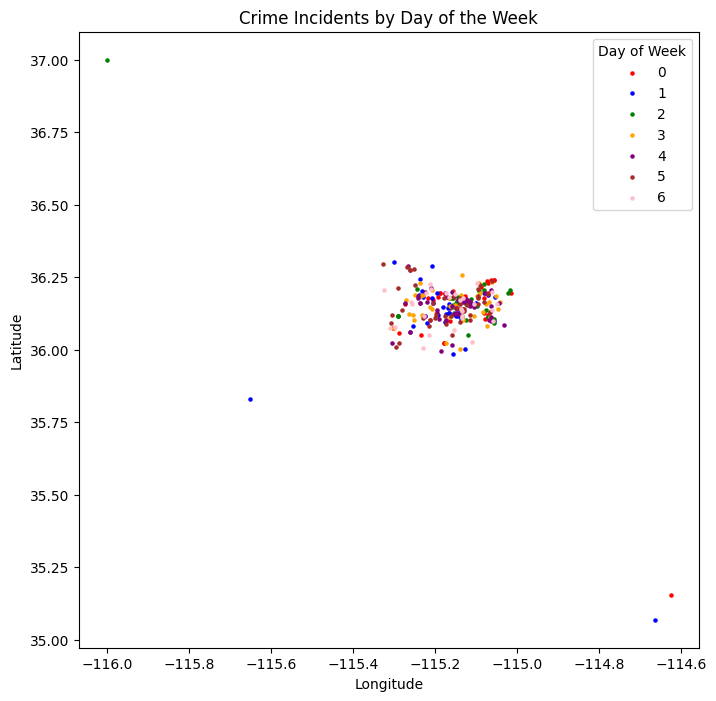

In [ ]:
colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'brown',
    6: 'pink'
}

plt.figure(figsize=(8,8))
for day, color in colors.items():
  day_of_week = df[df['DayOfWeek'] == day]
  plt.scatter(day_of_week['X'], day_of_week['Y'], label=day, c=color, s=5)

plt.title('Crime Incidents by Day of the Week')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Day of Week')

# Show the plot
plt.show()


There is a pattern. It seems that the majority of these crimes are occuring in the Downtown Las Vegas area. It also seems that most of the crimes take place towards the end of the week/ the beginning of the weekend.

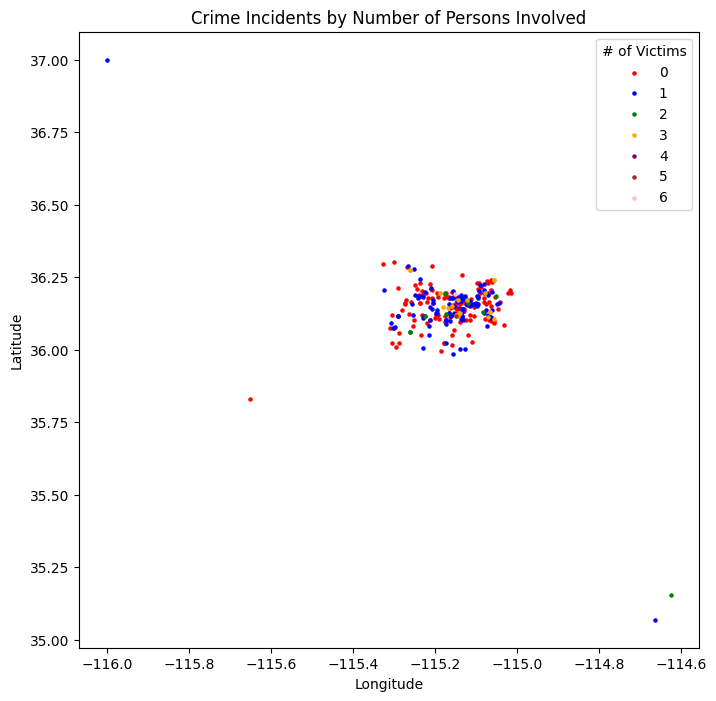

In [ ]:
# Create a scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

# Define a custom list of colors based on 'VictimCount'
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']

# Create a scatter plot with custom colors based on 'VictimCount' and add labels
for count, color in enumerate(colors):
    victim_df = df[df['VictimCount'] == count]
    plt.scatter(victim_df['X'], victim_df['Y'], label=f'{count}', c=color, s=5)

# Customize the plot for number of persons involved
plt.title('Crime Incidents by Number of Persons Involved')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='# of Victims')

plt.show()

By looking at this plot we can see that a very large majority of the crimes involve either 1 or 0 persons.


In [ ]:
# Group the data by 'DayOfWeek' and count the number of crimes for each day
day_counts = df['DayOfWeek'].value_counts().reset_index()

# Rename the columns for clarity
day_counts.columns = ['DayOfWeek', 'CrimeCount']

# Sort the data by the number of crimes in descending order
sorted = day_counts.sort_values(by='CrimeCount', ascending=False)

# Print the result
print(sorted.to_string(index=False))

 DayOfWeek  CrimeCount
         4          51
         3          44
         5          43
         0          40
         1          37
         2          32
         6          28


The most frequent days are Day 4 and Day 3.